## Monk's Problem - SVM

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve

from utils_monk import read_split_data, abs_path

## Task \#1

### Building the model and training

In [8]:
def model_selection(x, y):

    #Model
    classifier = SVC()

    # List of parameters to try
    SVC_params =  {'kernel' : ['linear','rbf', 'sigmoid'], 
              'gamma' : [0.01, 0.1, 1],
              'C': [0.1, 1, 10], 
               'class_weight' : [None, 'balanced']}
    
    # Folds
    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
    
    # Grid Search
    SVC_grid = GridSearchCV(estimator=classifier, 
                        param_grid=SVC_params, 
                        n_jobs=2, 
                        cv=folds,
                        scoring = 'accuracy',
                        verbose=2,
                        return_train_score=True)
    
    # Grid results
    grid_results = SVC_grid.fit(x, y)

    means_train = abs(grid_results.cv_results_['mean_train_score'])
    means_test = abs(grid_results.cv_results_['mean_test_score'])
    times_train = grid_results.cv_results_['mean_fit_time']
    times_test = grid_results.cv_results_['mean_score_time']
    params = grid_results.cv_results_['params']

    #for m_ts, t_ts, m_tr, t_tr, p in sorted(zip(means_test, times_test, means_train, times_train, params)):
    #    print("{} \t TR {:.4f} (in {:.4f}) \t TS {:.4f} (in {:.4f})".format(p, m_tr, t_tr, m_ts, t_ts))



    return grid_results.best_params_

In [9]:
def predict(model, x, y):

    y_pred = model.predict(x)

    MSE = mean_squared_error(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return y_pred, MSE, accuracy

In [10]:
def plot_learning_curve(model, x, y, savefig = False):
    p = model.get_params()
    params = dict(kernel=p['kernel'], C=p['C'],
                  gamma=p['gamma'], class_weight = p['class_weight'])
    
    train_sizes, train_scores_svc, test_scores_svc = learning_curve(model, x, y, train_sizes=np.linspace(0.1, 1, 60), n_jobs = 2, cv = 62, verbose=1)

    plt.plot(train_sizes, np.mean(np.abs(train_scores_svc), axis=1))
    plt.plot(train_sizes, np.mean(np.abs(test_scores_svc), axis=1))
    plt.xlabel("train size")
    plt.ylabel("Accuracy")
    plt.legend(['Accuracy TR', 'Accuracy VL'])
    plt.title(f'SVR learning curve \n {params}')

    if savefig:
        plt.savefig("plot\svc_3", transparent = True)

    plt.show()


In [11]:
def modeling_svm():

    # Encoder
    encoder = OneHotEncoder()

    # Getting the path to the file
    data_path_train = abs_path('monks-3.train', 'data')
    data_path_test = abs_path('monks-3.test', 'data')   

    # Splitting and encoding the training data
    X_train, y_train = read_split_data(data_path_train)
    X_train = encoder.fit_transform(X_train)

    # Splitting and encoding the test data
    X_test, y_test = read_split_data(data_path_test)
    X_test = encoder.transform(X_test)

    # Finding the best parameters through the grid search
    best_parameters = model_selection(X_train, y_train)
    print("Best parameters: ", best_parameters)

    # Building a model with the best parameters
    svc = SVC(**best_parameters, random_state = 42)

    folds = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Dividing training set in train and val 
    for train_index, val_index in folds.split(X_train, y_train):
        x_train = X_train[train_index]
        x_val = X_train[val_index]
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]
        
        svc.fit(x_train, y_train_fold)
        
        y_train_pred = svc.predict(x_train)
        y_val_pred = svc.predict(x_val)

        train_losses.append(mean_squared_error(y_train_fold, y_train_pred))
        val_losses.append(mean_squared_error(y_val_fold, y_val_pred))

        train_accuracies.append(accuracy_score(y_train_fold, y_train_pred))
        val_accuracies.append(accuracy_score(y_val_fold, y_val_pred))
    
    # Predicting on test set
    y_test_pred, test_loss, test_accuracy = predict(model = svc, x = X_test, y = y_test)

    print("Training loss: ", np.mean(train_losses))
    print("Validation loss: ", np.mean(val_losses))
    print("Test loss: ", test_loss)

    print("Training accuracy: ", np.mean(train_accuracies))
    print("Validation accuracy: ", np.mean(val_accuracies))
    print("Test accuracy: ", test_accuracy)

    print(classification_report(y_test_pred, y_test))

    plot_learning_curve(svc, X_train, y_train, savefig=True)




Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters:  {'C': 0.1, 'class_weight': None, 'gamma': 0.01, 'kernel': 'linear'}
Training loss:  0.06558798999165971
Validation loss:  0.06666666666666667
Test loss:  0.027777777777777776
Training accuracy:  0.9344120100083403
Validation accuracy:  0.9333333333333332
Test accuracy:  0.9722222222222222
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       216
           1       0.95      1.00      0.97       216

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

[learning_curve] Training set sizes: [ 12  13  15  17  19  21  22  24  26  28  30  32  33  35  37  39  41  43
  44  46  48  50  52  54  55  57  59  61  63  65  66  68  70  72  74  76
  77  79  81  83  85  87  88  90  92  94  96  98  99 101 103 105 107 109
 110 112 114 116 118 120]


C:\Users\cinna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 60 members, which is less than n_splits=62.
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 3720 out of 3720 | elapsed:   16.8s finished


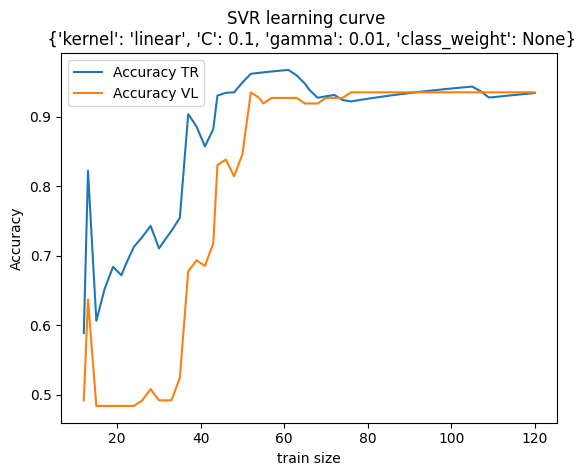

In [12]:
modeling_svm()